# Practical 10 GAN MNIST Fashion dataset

- Basic DCGAN implementation for MNIST like image generation
- Possible enhancement can be 1.better initialization of generator's and discriminator's layers 2. Using better Betas for Adam 3. More Epochs 4. Working on Generator for reducing its loss

In [1]:
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torch import optim
import torch
from matplotlib import pyplot as plt

In [3]:
if torch.cuda.is_available():
    device=torch.device(type='cuda',index=0)
else:
    device=torch.device(type='cpu',index=0)

In [4]:
train_data=datasets.FashionMNIST(root='/kaggle/temp/mnist_train', train=True, download=True, transform=transforms.Compose([transforms.Resize(32), transforms.ToTensor(),transforms.Normalize([0.5],[0.5])]))

100%|██████████| 26421880/26421880 [00:00<00:00, 124658349.06it/s]


Extracting /kaggle/temp/mnist_train/FashionMNIST/raw/train-images-idx3-ubyte.gz to /kaggle/temp/mnist_train/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 4941911.48it/s]

Extracting /kaggle/temp/mnist_train/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/temp/mnist_train/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 62033485.98it/s]


Extracting /kaggle/temp/mnist_train/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/temp/mnist_train/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8105209.08it/s]


Extracting /kaggle/temp/mnist_train/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/temp/mnist_train/FashionMNIST/raw



In [5]:
batch_size=64

In [6]:
train_dataloader=DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

In [7]:
def convblock(in_channels,out_channels,kernel_size=4,stride=2,padding=1):
    layers=[nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding)]
    layers.append(nn.BatchNorm2d(num_features=out_channels))
    layers.append(nn.LeakyReLU(0.2))
    return nn.Sequential(*layers)

def tconvblock(in_channels,out_channels,kernel_size=4,stride=2,padding=1):
    layers=[nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding)]
    layers.append(nn.BatchNorm2d(num_features=out_channels))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout2d(0.25))
    return nn.Sequential(*layers)

In [8]:
class Generator(nn.Module):
    def __init__(self,latent_dim, img_size):
        super().__init__()
        self.latent_dim=latent_dim
        self.img_size=img_size
        self.init_size=self.img_size//4

        self.lin=nn.Linear(in_features=self.latent_dim,out_features=128*self.init_size*self.init_size )

        self.tconvblocks=nn.Sequential(tconvblock(128,64,4,2,1),tconvblock(64,32,4,2,1))

        self.convtanh=nn.Sequential(nn.Conv2d(32,1,3,1,1),nn.Tanh())


    def forward(self,x):
        x=self.lin(x)
        x=x.view(x.shape[0],128,self.init_size,self.init_size)
        x=self.tconvblocks(x)
        x=self.convtanh(x)

        return x

class Discriminator(nn.Module):
    def __init__(self, img_size):
        super().__init__()

        self.img_size=img_size

        self.convblocks=nn.Sequential(convblock(1,16,4,2,1), convblock(16,32,4,2,1), convblock(32,64,4,2,1),convblock(64,128,4,2,1))

        self.out=nn.Sequential(nn.Linear(128*(self.img_size//(2**(len(self.convblocks)-1))),2))

    def forward(self,x):
        x=self.convblocks(x)
        x=x.view(x.shape[0],-1)
        pred=self.out(x)
        return pred

In [9]:
loss_fn=nn.CrossEntropyLoss().to(device)
n_epochs=5 #actually, you should run for more epochs, may be 200
lr=0.0002

generator=Generator(100,32).to(device)
discriminator=Discriminator(32).to(device)

gopt=optim.Adam(params=generator.parameters(),lr=lr)
dopt=optim.Adam(params=discriminator.parameters(),lr=lr)

In [10]:
def train_one_epoch(plt):
    for i,(imgs,_) in enumerate(train_dataloader):

        noise_vectors=torch.randn((imgs.shape[0],100)).to(device)

        zero_labels=torch.zeros((imgs.shape[0])).to(device).type(torch.int64)
        one_labels=torch.ones((imgs.shape[0])).to(device).type(torch.int64)

        fake_images=generator(noise_vectors)

        pred=discriminator(fake_images)

        gloss=loss_fn(pred,one_labels)
        gopt.zero_grad()
        gloss.backward()
        gopt.step()


        real_imgs=imgs.to(device)

        pred_on_real=discriminator(real_imgs)
        dloss_on_real=loss_fn(pred_on_real,one_labels)
        pred_on_fake=discriminator(fake_images.detach())
        dloss_on_fake=loss_fn(pred_on_fake,zero_labels)
        dloss=(dloss_on_real+dloss_on_fake)/2

        dopt.zero_grad()
        dloss.backward()
        dopt.step()

        if i%500 == 0:

            print("Batch No.:", i+1,"/",len(train_dataloader),":", "GLoss=",round(gloss.item(),4), "DLoss=",round(dloss.item(),4))
            for j in range(64):
                plt.subplot(8,8,j+1)
                plt.imshow(torch.permute(fake_images[j],(1,2,0)).detach().cpu(),interpolation='nearest', cmap='gray_r')

            plt.show()


In [11]:
from sklearn.metrics import accuracy_score

In [12]:
def accuracy(pred_on_real, pred_on_fake):
    a = tourch.argmax()
    b = tourch.argmax()

Epoch 1 / 5 :
Batch No.: 1 / 938 : GLoss= 0.558 DLoss= 0.7144


/tmp/ipykernel_34/388914250.py:35: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(8,8,j+1)


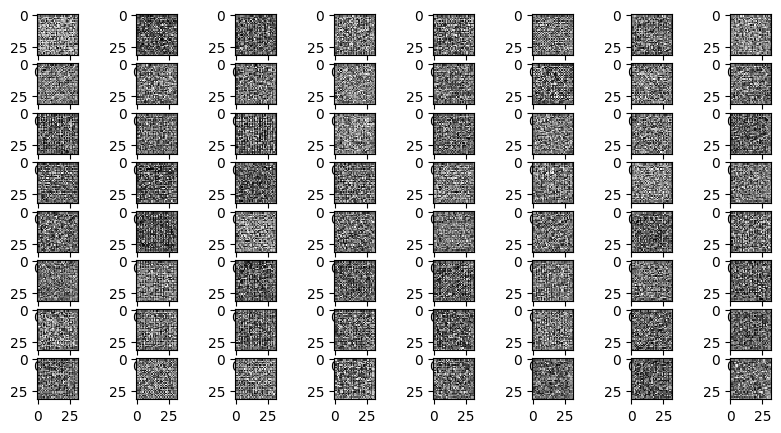

Batch No.: 501 / 938 : GLoss= 3.7714 DLoss= 0.2104


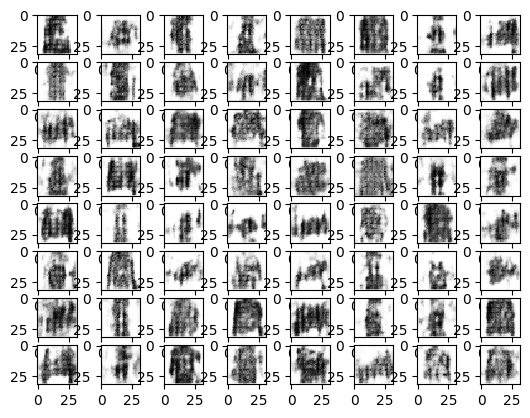

Epoch 2 / 5 :
Batch No.: 1 / 938 : GLoss= 6.5565 DLoss= 0.0774


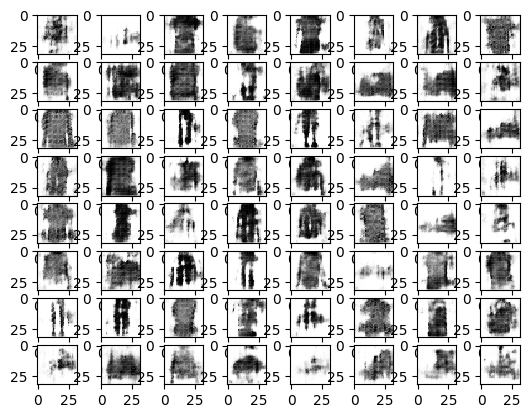

Batch No.: 501 / 938 : GLoss= 1.45 DLoss= 0.2537


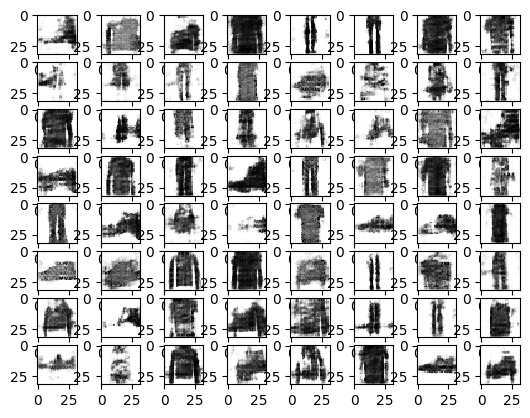

Epoch 3 / 5 :
Batch No.: 1 / 938 : GLoss= 3.5426 DLoss= 0.1421


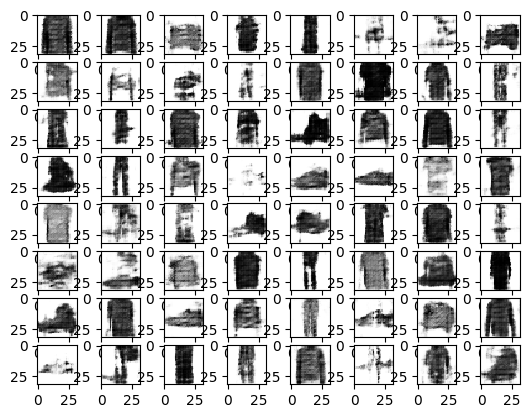

Batch No.: 501 / 938 : GLoss= 4.3693 DLoss= 0.0613


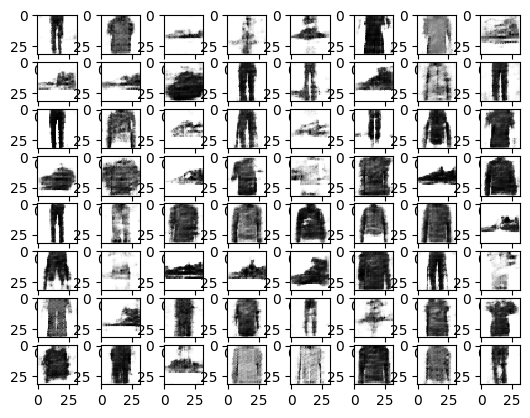

Epoch 4 / 5 :
Batch No.: 1 / 938 : GLoss= 4.2333 DLoss= 0.0389


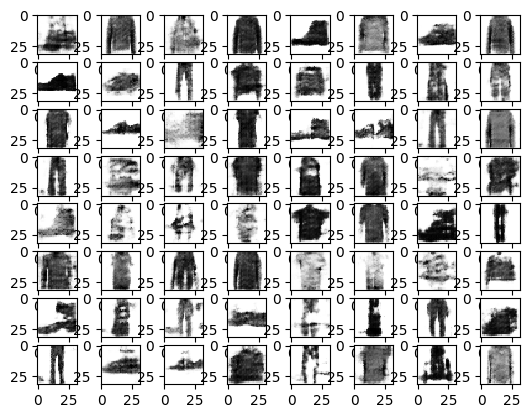

Batch No.: 501 / 938 : GLoss= 2.4882 DLoss= 0.0881


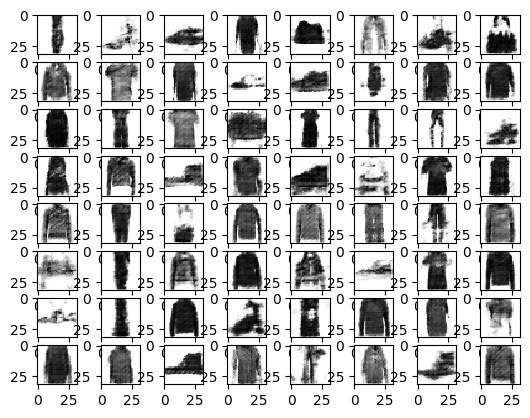

Epoch 5 / 5 :
Batch No.: 1 / 938 : GLoss= 5.4012 DLoss= 0.0515


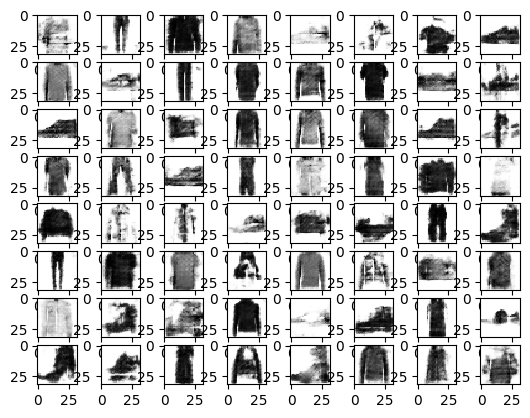

Batch No.: 501 / 938 : GLoss= 3.7074 DLoss= 0.0341


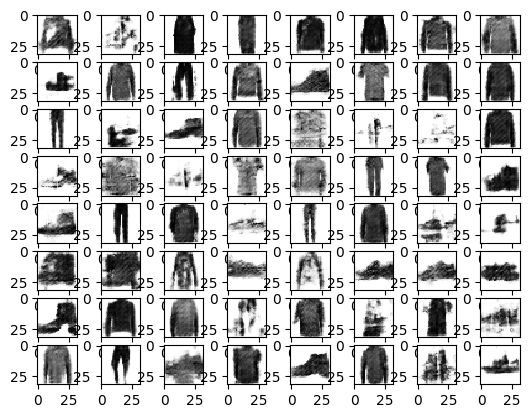

In [13]:
plt.figure(figsize=(10,5))
plt.title("Generated Images")
for e in range(n_epochs):
    print("Epoch",e+1,"/",n_epochs,":")
    train_one_epoch(plt)

Here instead of Mnist dataset i used the MnistFashon dataset, All the logic of generator and descriminator is same as Mnist_GAN.